In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import random
import warnings
import sncosmo
import os 
import glob
import numpy as np
    
warnings.filterwarnings("ignore")

from read_yse_ztf_snana_dir import read_YSE_ZTF_snana_dir
from plot_yse_ztf_file import get_grizXY_plot

#plt.style.use('fig_publication-hists.mplstyle')
%config InlineBackend.figure_format = 'retina'

# Colorblind friendly colors https://gist.github.com/thriveth/8560036
# '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'
# blue       orange       green    pink        brown      purple      grey       red        yellow

if not os.path.exists(f'../Figures/Paper/distributions'):
    os.makedirs(f'../Figures/Paper/distributions')

In [2]:
def read_snana_fits(dir_path,axis,fileIdx, snIdx, plot_flux=True):

    
    heads = sorted(glob.glob(os.path.join(dir_path, '*_HEAD.FITS.gz')))
    phots = sorted(glob.glob(os.path.join(dir_path, '*_PHOT.FITS.gz')))
    assert len(heads) != 0, 'no *_HEAD_FITS.gz are found'
    assert len(heads) == len(phots), 'there are different number of HEAD and PHOT files'
    
    pkmag_rs, redshifts, nobs_to_peaks, nobs_after_peaks, pkSNRs, lc_dfs = [],[],[],[],[],[]

    for head, phot in zip(heads[fileIdx:fileIdx+1], phots[fileIdx:fileIdx+1]): #lots of LCs per head, phot files, so do a few to start
        i = head.find('_HEAD.FITS.gz')
        assert head[:i] == phot[:i], f'HEAD and PHOT files name mismatch: {head}, {phot}'
        filename = head[:i].split('/')[-1].split('.')[0]

        for LCnum, lc in enumerate(sncosmo.read_snana_fits(head, phot)[snIdx:snIdx+1]): # remember: multiple SN in single HEAD/PHOT file
            # SNR>4, PHOTFLAG != 0 
            #print(lc.meta)
            #print(lc.columns)
            print(lc.meta["SIM_TYPE_NAME"])
            lc_df = lc.to_pandas()
            #print(lc_df)
            mask = (lc_df['PHOTFLAG'] != 0)
            lc_df = lc_df[mask].reset_index(drop=True)
            print(lc.meta['SIM_REDSHIFT_HOST'])
            #fig, ax = plt.subplots()
            lc_df['BAND']= lc_df['BAND'].str.decode("utf-8") # turn Bytes into str
            D_id_color = {
                      "X ": u"#b9ac70",
                      "Y ": u"#bd1f01",
                      "g ": u"#4daf4a", 
                      "r ": u"#e41a1c",
                      "i ": u"#832db6",
                      "z ": u"#656364"}
            lc_df['PLOTCOLOR'] = lc_df.BAND.map(D_id_color)
            
            if plot_flux == True:
                for pb, c in D_id_color.items():
                    lc_df_pb = lc_df[lc_df.BAND == pb]
                    axis.errorbar(lc_df_pb['MJD'], lc_df_pb['FLUXCAL'], yerr=lc_df_pb['FLUXCALERR'], 
                             c=c, fmt='o', label=pb, ms=7, elinewidth=2)
                #plt.ylabel('Flux')
                
                
            else:
                for pb, c in D_id_color.items():
                    lc_df_pb = lc_df[lc_df.BAND == pb]
                    snr = lc_df_pb['FLUXCAL']/lc_df_pb['FLUXCALERR'] 
                    lc_df_pb['MAG'] = np.array(-2.5*np.log10(np.abs(lc_df_pb['FLUXCAL'])))+27.5
                    lc_df_pb['MAGERR'] = 1.086/snr
                    
                    axis.errorbar(lc_df_pb['MJD'], lc_df_pb['MAG'],lc_df_pb['MAGERR'], 
                             c=c, fmt='o', label=pb, ms=7, elinewidth=2)
                
                #plt.ylabel('Mag (ZP=27.5)')
                #plt.gca().invert_yaxis()
            #plt.xlabel('MJD')
            #plt.show()

In [3]:
def read_snana_fits2(dir_path,axis,fileIdx, snIdx,minObs, plot_flux=True):

    
    heads = sorted(glob.glob(os.path.join(dir_path, '*_HEAD.FITS.gz')))
    phots = sorted(glob.glob(os.path.join(dir_path, '*_PHOT.FITS.gz')))
    assert len(heads) != 0, 'no *_HEAD_FITS.gz are found'
    assert len(heads) == len(phots), 'there are different number of HEAD and PHOT files'
    
    pkmag_rs, redshifts, nobs_to_peaks, nobs_after_peaks, pkSNRs, lc_dfs = [],[],[],[],[],[]

    for head, phot in zip(heads[fileIdx:fileIdx+2], phots[fileIdx:fileIdx+2]): #lots of LCs per head, phot files, so do a few to start
        i = head.find('_HEAD.FITS.gz')
        assert head[:i] == phot[:i], f'HEAD and PHOT files name mismatch: {head}, {phot}'
        filename = head[:i].split('/')[-1].split('.')[0]

        for LCnum, lc in enumerate(sncosmo.read_snana_fits(head, phot)[snIdx:snIdx+5]): # remember: multiple SN in single HEAD/PHOT file
            # SNR>4, PHOTFLAG != 0 
            
            #print(lc.columns)
            
            lc_df = lc.to_pandas()

            mask = (lc_df['PHOTFLAG'] != 0)
            lc_df = lc_df[mask].reset_index(drop=True)
            
            if (lc_df.shape[0] < minObs):
                continue
            else:
                print(lc.meta['SIM_REDSHIFT_HOST'])
                print(lc.meta["SIM_TYPE_NAME"])
                print(LCnum)
            #fig, ax = plt.subplots()
            lc_df['BAND']= lc_df['BAND'].str.decode("utf-8") # turn Bytes into str
            D_id_color = {
                      "X ": u"#b9ac70",
                      "Y ": u"#bd1f01",
                      "g ": u"#4daf4a", 
                      "r ": u"#e41a1c",
                      "i ": u"#832db6",
                      "z ": u"#656364"}
            lc_df['PLOTCOLOR'] = lc_df.BAND.map(D_id_color)
            
            if plot_flux == True:
                for pb, c in D_id_color.items():
                    lc_df_pb = lc_df[lc_df.BAND == pb]
                    axis.errorbar(lc_df_pb['MJD'], lc_df_pb['FLUXCAL'], yerr=lc_df_pb['FLUXCALERR'], 
                             c=c, fmt='o', label=pb, ms=7, elinewidth=2)
                plt.ylabel('Flux')
                
                
            else:
                for pb, c in D_id_color.items():
                    lc_df_pb = lc_df[lc_df.BAND == pb]
                    snr = lc_df_pb['FLUXCAL']/lc_df_pb['FLUXCALERR'] 
                    lc_df_pb['MAG'] = np.array(-2.5*np.log10(np.abs(lc_df_pb['FLUXCAL'])))+27.5
                    lc_df_pb['MAGERR'] = 1.086/snr
                    
                    plt.scatter(lc_df_pb['MJD'], lc_df_pb['MAG'], 
                             c=c, label=pb)
                
                plt.ylabel('Mag (ZP=27.5)')
                plt.gca().invert_yaxis()
            plt.xlabel('MJD')
            plt.show()

In [4]:
def read_snana_fits3(dir_path):

    z_list = []
    
    heads = sorted(glob.glob(os.path.join(dir_path, '*_HEAD.FITS.gz')))
    phots = sorted(glob.glob(os.path.join(dir_path, '*_PHOT.FITS.gz')))
    assert len(heads) != 0, 'no *_HEAD_FITS.gz are found'
    assert len(heads) == len(phots), 'there are different number of HEAD and PHOT files'
    
    pkmag_rs, redshifts, nobs_to_peaks, nobs_after_peaks, pkSNRs, lc_dfs = [],[],[],[],[],[]

    for head, phot in zip(heads, phots): #lots of LCs per head, phot files, so do a few to start
        i = head.find('_HEAD.FITS.gz')
        assert head[:i] == phot[:i], f'HEAD and PHOT files name mismatch: {head}, {phot}'
        filename = head[:i].split('/')[-1].split('.')[0]

        for LCnum, lc in enumerate(sncosmo.read_snana_fits(head, phot)): # remember: multiple SN in single HEAD/PHOT file
            z_list.append(lc.meta['SIM_REDSHIFT_HOST'])

    return z_list

In [5]:
#redshifts = read_snana_fits3('./PALEO_YSE_ZTF_MODEL38/')

In [6]:
#redshifts = np.array(redshifts)

In [7]:
#print(np.argmin(redshifts))
#print(np.amax(redshifts))

0.031254087
b'Ib      '
1


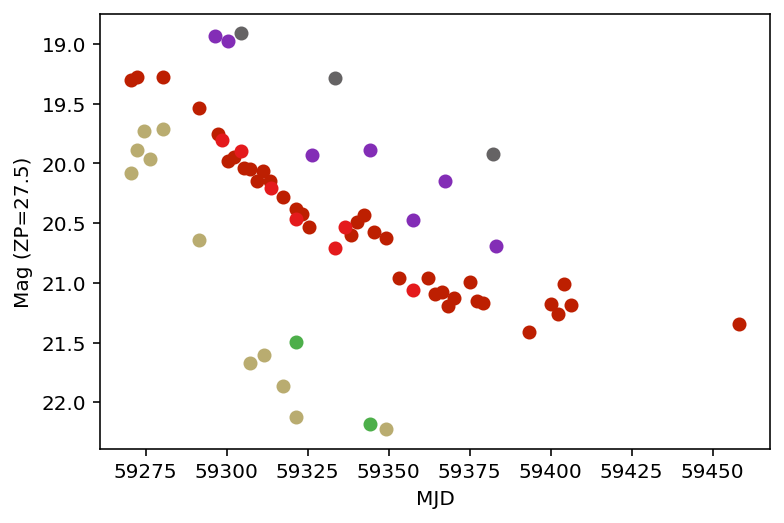

0.01814275
b'Ib      '
2


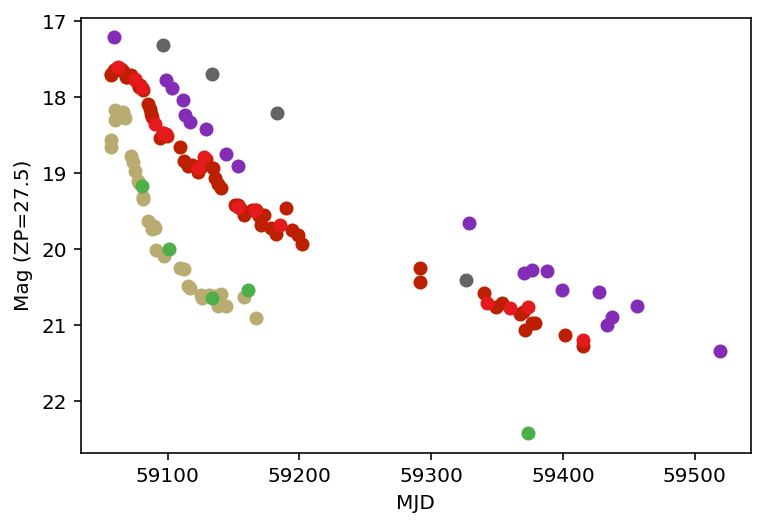

0.02827648
b'Ib      '
3


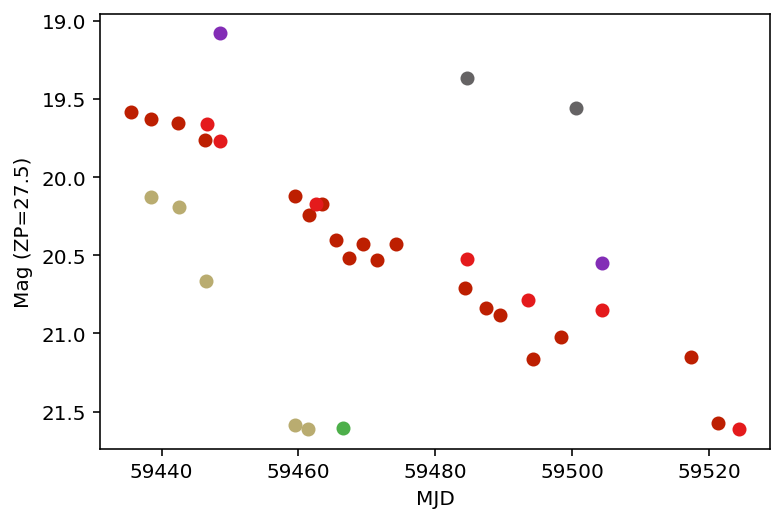

In [8]:
read_snana_fits2('./PALEO_YSE_ZTF_MODEL38/', None,12,240,30,plot_flux=False)

b'Ic      '
0.02348331


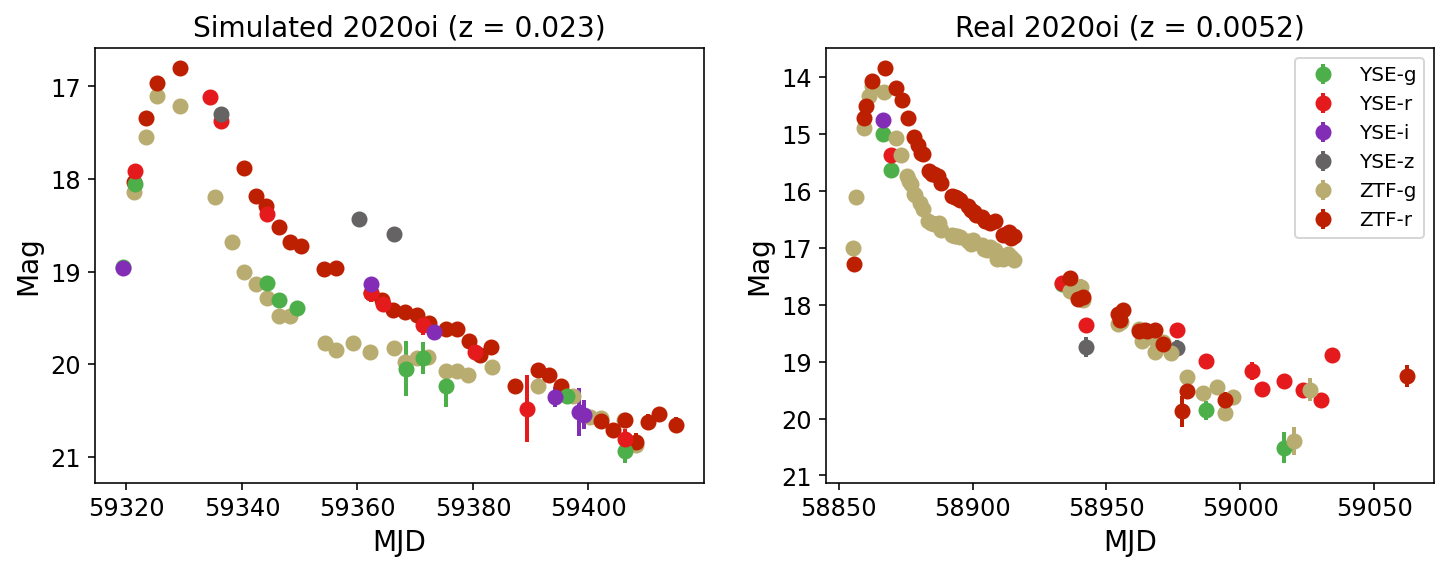

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

read_snana_fits('./PALEO_YSE_ZTF_MODEL38/', ax1,11,17,plot_flux=False)
get_grizXY_plot("./realPhotObs","2020oi",ax2)

ax1.invert_yaxis()
ax1.set_ylabel('Mag',fontsize = 14)
ax1.set_xlabel('MJD',fontsize = 14)
ax1.set_title('Simulated 2020oi (z = 0.023)',fontsize = 14)
ax2.set_ylabel('Mag',fontsize = 14)
ax2.set_xlabel('MJD',fontsize = 14)
ax2.set_title('Real 2020oi (z = 0.0052)',fontsize = 14)
ax1.tick_params("both",labelsize = 12)
ax2.tick_params("both",labelsize = 12)
plt.gca().invert_yaxis()

plt.legend()
plt.savefig('SN2020oi.png', bbox_inches='tight')
plt.show()

b'IIP     '
0.07485543


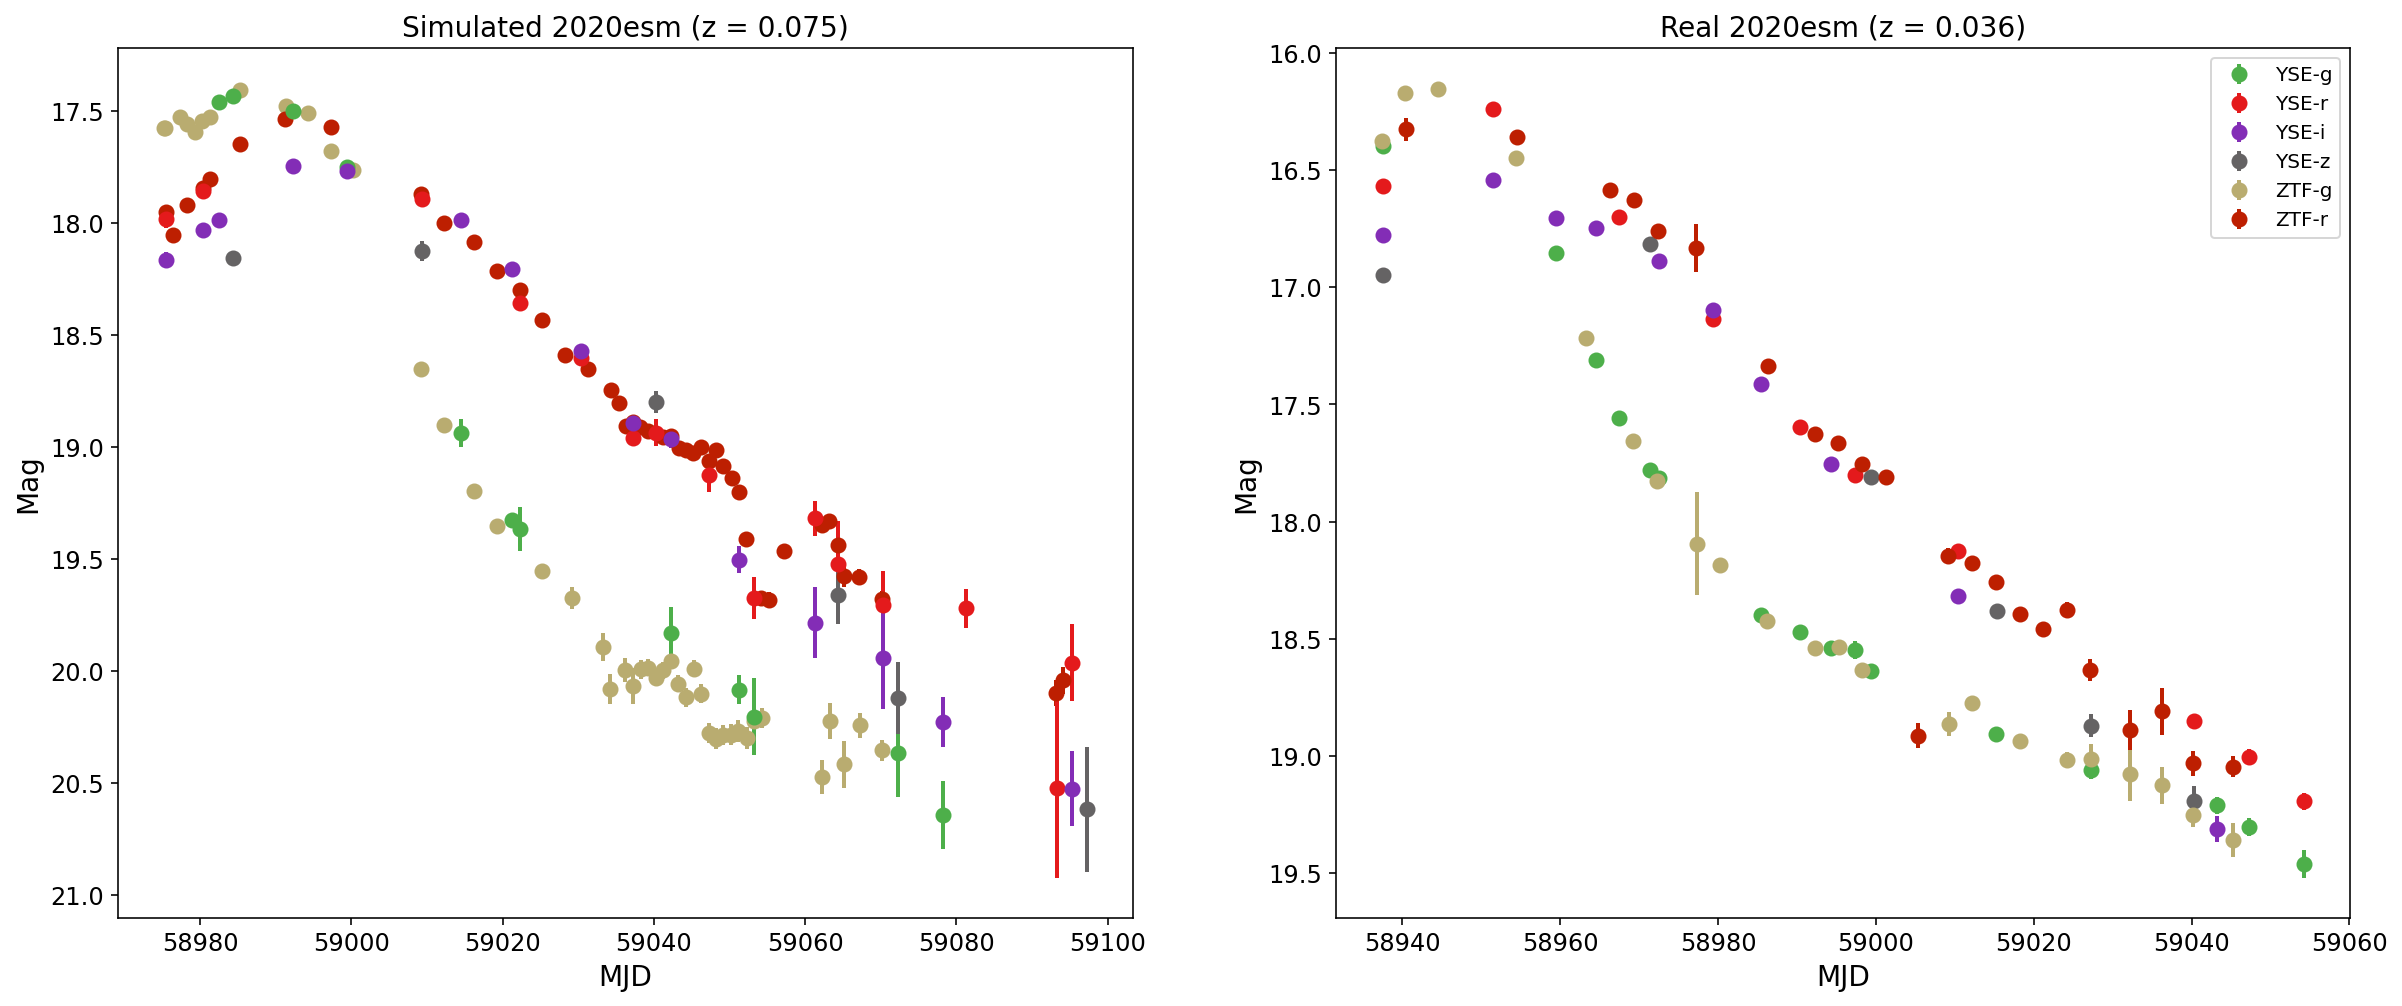

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,8))

read_snana_fits('./PALEO_YSE_ZTF_MODEL38/', ax1,9,65,plot_flux=False)
get_grizXY_plot("./realPhotObs","2020esm",ax2)

ax1.invert_yaxis()
ax1.set_ylabel('Mag',fontsize = 14)
ax1.set_xlabel('MJD',fontsize = 14)
ax1.set_title('Simulated 2020esm (z = 0.075)',fontsize = 14)
ax2.set_ylabel('Mag',fontsize = 14)
ax2.set_xlabel('MJD',fontsize = 14)
ax2.set_title('Real 2020esm (z = 0.036)',fontsize = 14)
ax1.tick_params("both",labelsize = 12)
ax2.tick_params("both",labelsize = 12)
plt.gca().invert_yaxis()

plt.legend()
plt.savefig('SN2020esm.png', bbox_inches='tight')
plt.show()

b'IIb     '
0.033663906


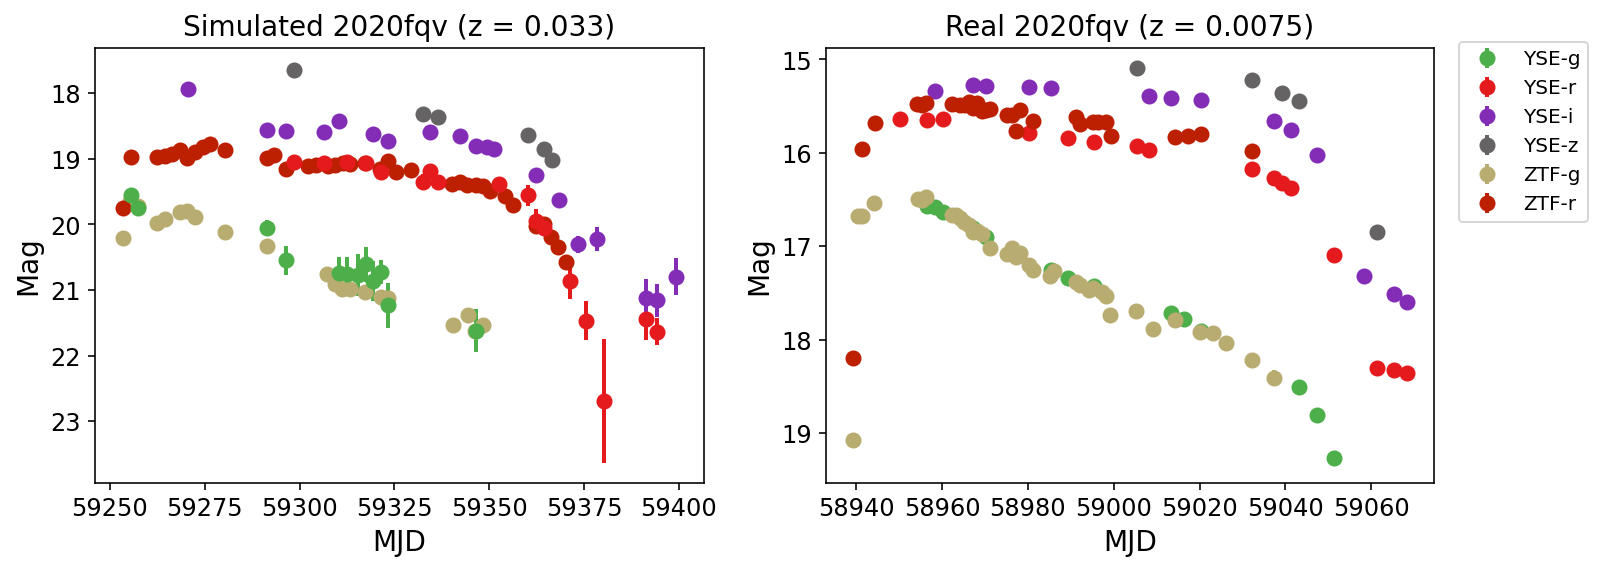

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

read_snana_fits('./PALEO_YSE_ZTF_MODEL38/', ax1,34,201,plot_flux=False)
get_grizXY_plot("./realPhotObs","2020fqv",ax2)

ax1.invert_yaxis()
ax1.set_ylabel('Mag',fontsize = 14)
ax1.set_xlabel('MJD',fontsize = 14)
ax1.set_title('Simulated 2020fqv (z = 0.033)',fontsize = 14)
ax2.set_ylabel('Mag',fontsize = 14)
ax2.set_xlabel('MJD',fontsize = 14)
ax2.set_title('Real 2020fqv (z = 0.0075)',fontsize = 14)
ax1.tick_params("both",labelsize = 12)
ax2.tick_params("both",labelsize = 12)
plt.gca().invert_yaxis()

plt.legend(loc=(1.04,0.6))
plt.savefig('SN2020fqv.png', bbox_inches='tight')
plt.show()

b'Ib      '
0.01814275


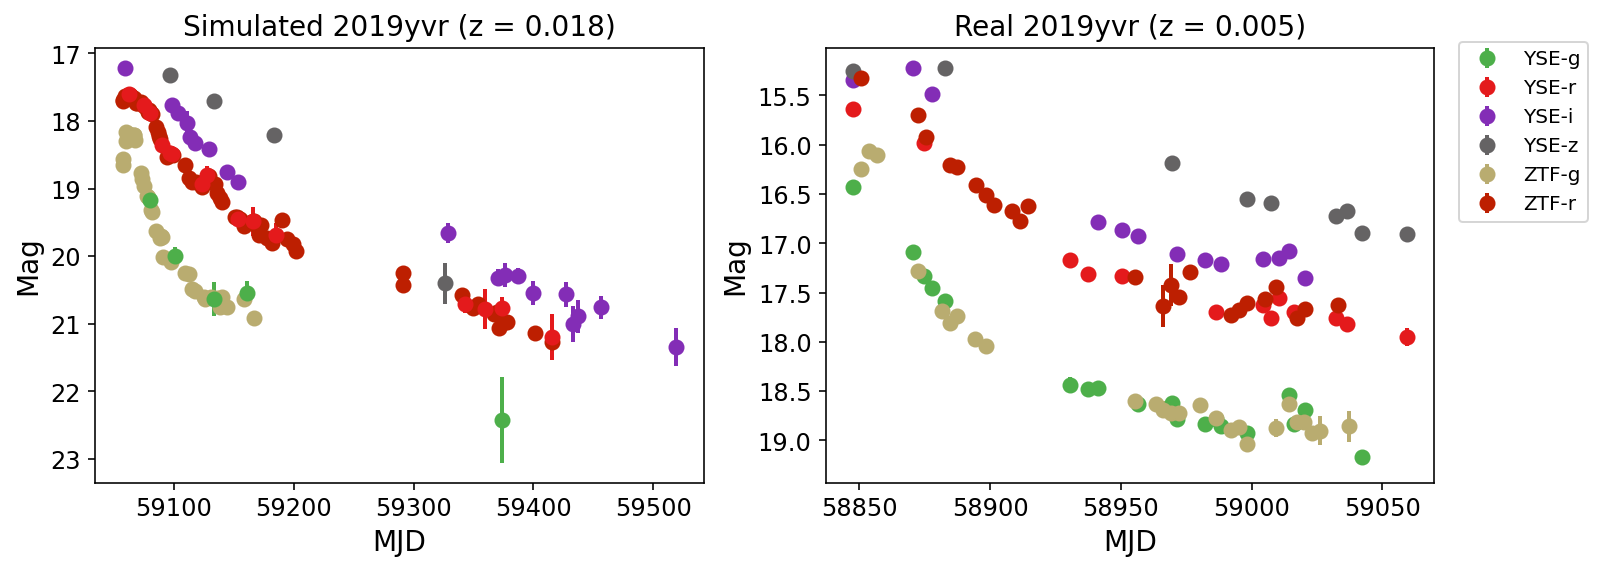

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

read_snana_fits('./PALEO_YSE_ZTF_MODEL38/', ax1,12,242,plot_flux=False)
get_grizXY_plot("./realPhotObs","2019yvr",ax2)

ax1.invert_yaxis()
ax1.set_ylabel('Mag',fontsize = 14)
ax1.set_xlabel('MJD',fontsize = 14)
ax1.set_title('Simulated 2019yvr (z = 0.018)',fontsize = 14)
ax2.set_ylabel('Mag',fontsize = 14)
ax2.set_xlabel('MJD',fontsize = 14)
ax2.set_title('Real 2019yvr (z = 0.005)',fontsize = 14)
ax1.tick_params("both",labelsize = 12)
ax2.tick_params("both",labelsize = 12)
plt.gca().invert_yaxis()

plt.legend(loc=(1.04,0.6))
plt.savefig('SN2019yvr.png', bbox_inches='tight')
plt.show()

b'Ic      '
0.0813388
b'Ib      '
0.06161275


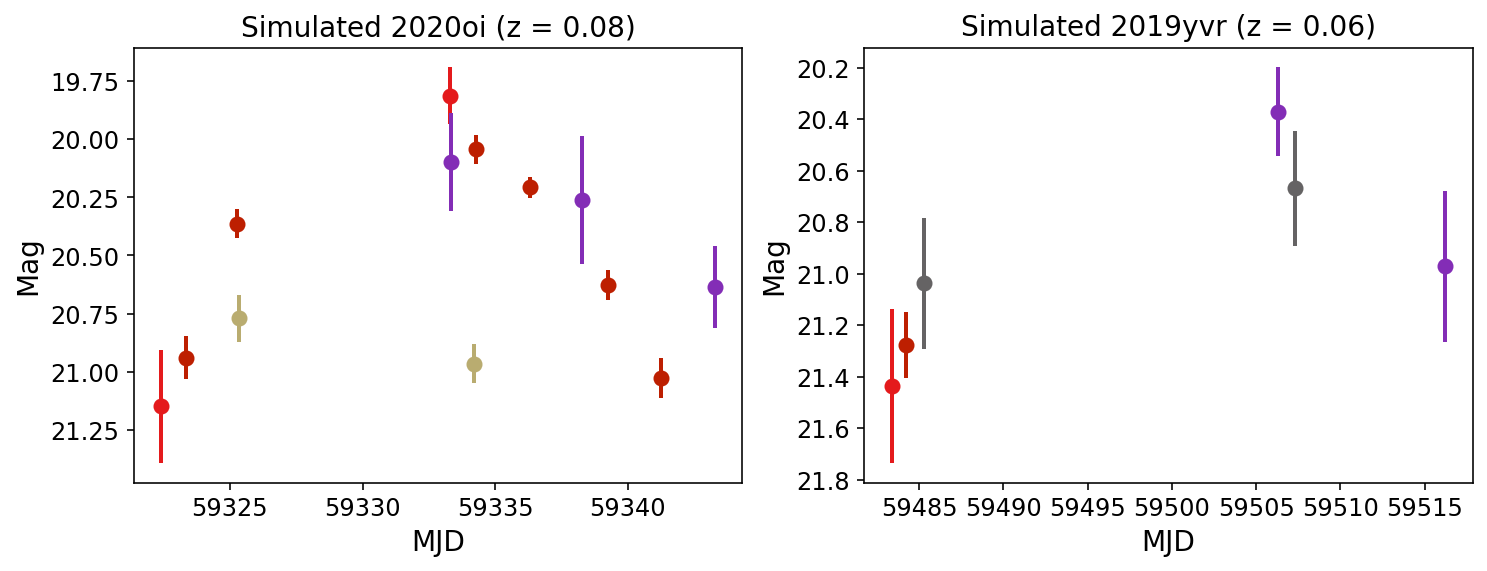

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

read_snana_fits('./PALEO_YSE_ZTF_MODEL38/', ax1,1,20,plot_flux=False)
read_snana_fits('./PALEO_YSE_ZTF_MODEL38/', ax2,4,215,plot_flux=False)

ax1.invert_yaxis()
ax1.set_ylabel('Mag',fontsize = 14)
ax1.set_xlabel('MJD',fontsize = 14)
ax1.set_title('Simulated 2020oi (z = 0.08)',fontsize = 14)
ax2.set_ylabel('Mag',fontsize = 14)
ax2.set_xlabel('MJD',fontsize = 14)
ax2.set_title('Simulated 2019yvr (z = 0.06)',fontsize = 14)
ax1.tick_params("both",labelsize = 12)
ax2.tick_params("both",labelsize = 12)
plt.gca().invert_yaxis()

plt.savefig('badSims.png', bbox_inches='tight')
plt.show()

In [14]:
def plotSpec(dir,axis = None ,roll = False):
    spec_curve = pd.read_csv(dir, delim_whitespace=True)
    #spec_curve.rename(columns = [1])
    if (roll):
        spec_curve["flux"] = spec_curve["flux"].rolling(5).mean()
    wavelen = spec_curve.iloc[:,0]
    fluxs = spec_curve.iloc[:,1]
    wavelen.to_numpy()
    fluxs.to_numpy()
    if (axis == None):
        plt.plot(wavelen,fluxs)
    else:
        axis.plot(wavelen,fluxs)

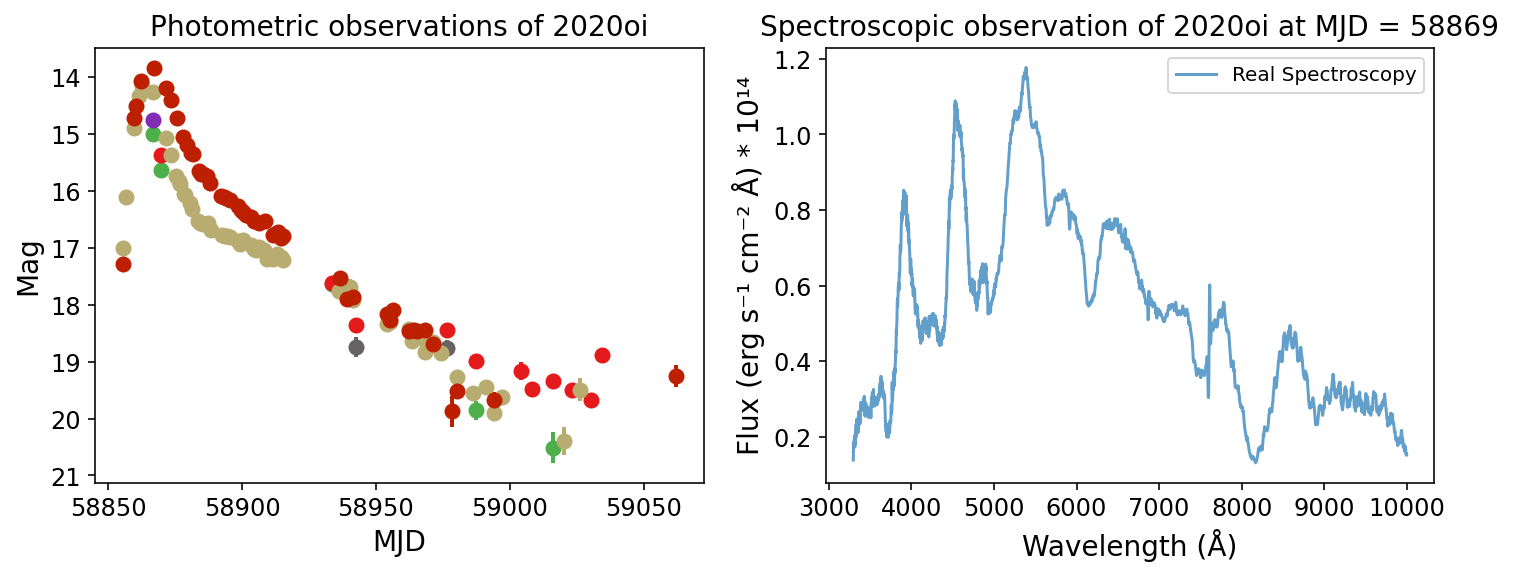

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

get_grizXY_plot("./realPhotObs","2020oi",ax1)

ax1.set_ylabel('Mag',fontsize = 14)
ax1.set_xlabel('MJD',fontsize = 14)
ax1.set_title('Photometric observations of 2020oi',fontsize = 14)
ax1.tick_params("both",labelsize = 12)
ax1.invert_yaxis()

spec_curve = pd.read_csv("spec//2020oi//58868.638.txt", delim_whitespace=True)
wavelen = spec_curve.iloc[:,0]
fluxs = spec_curve.iloc[:,1]
wavelen.to_numpy()
fluxs.to_numpy()

ax2.plot(wavelen*1,fluxs*1e+14,label = "Real Spectroscopy",alpha = 0.7)
ax2.set_ylabel('Flux (erg s⁻¹ cm⁻² Å) * 10¹⁴',fontsize = 14)
ax2.set_xlabel('Wavelength (Å)',fontsize = 14)
ax2.set_title('Spectroscopic observation of 2020oi at MJD = 58869',fontsize = 14)
ax2.tick_params("both",labelsize = 12)

plt.legend()
plt.savefig('SN2020oi.png', bbox_inches='tight')
plt.show()